<a href="https://colab.research.google.com/github/dev-yusupov/nasa-space-apps-models/blob/main/weather_humidity_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Collection**

In [23]:
import requests
import pandas as pd

# Base API URL
url = "https://power.larc.nasa.gov/api/temporal/daily/point"

# Define a function to get data for a specific district
def get_weather_data(lat, lon, start_date, end_date):
    params = {
        'start': start_date,        # Start date (YYYYMMDD)
        'end': end_date,            # End date (YYYYMMDD)
        'latitude': lat,            # Latitude
        'longitude': lon,           # Longitude
        'community': 'ag',          # Community (agriculture)
        'parameters': ','.join([
            'RH2M',                 # Relative Humidity at 2 meters
            'T2M',                  # Temperature at 2 meters
            'ALLSKY_SFC_SW_DWN',     # Solar Radiation
            'WS10M',                # Wind Speed at 10 meters
            'PRECTOTCORR'            # Precipitation
        ]),
        'format': 'JSON',           # Data format (JSON)
        'header': 'true',           # Include metadata
    }

    # Make the API request
    response = requests.get(url, params=params)
    data = response.json()

    # Extract parameters from the response
    weather_data = data['properties']['parameter']

    return weather_data

# Define districts with latitude and longitude
districts = {
    'JRASULOV': (40.1472529, 69.4455232),
    'KHUJAND': (40.2866013, 69.5545262),
    "DUSHANBE": (38.561295, 68.6991805),
    "BOKHTAR": (37.8397975, 68.7605088),
    "KULOB": (37.9290324, 69.7139138),
    "ISTARAVSHAN": (39.9083057, 68.9852065),
    "BGAFUROV": (40.1776623, 69.5781556),
}

# Collect data for all districts
all_data = []

for district, (lat, lon) in districts.items():
    # Get weather data for each district
    weather_data = get_weather_data(lat, lon, '20000101', '20240930')

    # Create a DataFrame for each parameter and merge them by Date
    df = pd.DataFrame({
        'Date': weather_data['RH2M'].keys(),
        'Relative Humidity (%)': weather_data['RH2M'].values(),
        'Temperature (C)': weather_data['T2M'].values(),
        'Solar Radiation (kWh/m²)': weather_data['ALLSKY_SFC_SW_DWN'].values(),
        'Wind Speed (m/s)': weather_data['WS10M'].values(),
        'Precipitation (mm)': weather_data['PRECTOTCORR'].values(),
    })

    # Add district name
    df['District'] = district

    # Append to all_data list
    all_data.append(df)

# Concatenate all district data into a final DataFrame
final_df = pd.concat(all_data, ignore_index=True)

# Sort by 'Date' to ensure all data is ordered by date
final_df.sort_values(by=['Date', 'District'], inplace=True)

# Display the first few rows of the combined data
print(final_df.head())

# Optionally, save to CSV for further use
final_df.to_csv('tajikistan_weather_data.csv', index=False)


           Date  Relative Humidity (%)  Temperature (C)  \
54240  20000101                  45.62             8.08   
27120  20000101                  41.56             9.37   
18080  20000101                  43.19             6.23   
45200  20000101                  49.25             8.28   
0      20000101                  45.62             8.08   

       Solar Radiation (kWh/m²)  Wind Speed (m/s)  Precipitation (mm)  \
54240                      9.48              2.63                 0.0   
27120                     10.84              1.81                 0.0   
18080                      8.93              2.10                 0.0   
45200                      9.55              2.80                 0.0   
0                          9.48              2.63                 0.0   

          District  
54240     BGAFUROV  
27120      BOKHTAR  
18080     DUSHANBE  
45200  ISTARAVSHAN  
0         JRASULOV  


# **Data cleaning and normalization**


**

In [36]:
import pandas as pd
import numpy as np
from scipy import stats

data = pd.read_csv('data.csv')

# Calculate z-scores for numeric columns
z_scores = np.abs(stats.zscore(data.select_dtypes(include=[np.number])))

# Keep only rows where the z-score is below a threshold (e.g., 3 standard deviations)
data = data[(z_scores < 3).all(axis=1)]

# Display the cleaned data
data

,Date,Relative Humidity (%),Temperature (C),Solar Radiation (kWh/m²),Wind Speed (m/s),Precipitation (mm),District
0,20000101,45.62,8.08,9.48,2.63,0.00,BGAFUROV
1,20000101,41.56,9.37,10.84,1.81,0.00,BOKHTAR
2,20000101,43.19,6.23,8.93,2.10,0.00,DUSHANBE
3,20000101,49.25,8.28,9.55,2.80,0.00,ISTARAVSHAN
4,20000101,45.62,8.08,9.48,2.63,0.00,JRASULOV
...,...,...,...,...,...,...,...
63275,20240930,86.75,13.18,2.98,1.63,20.89,DUSHANBE
63276,20240930,67.62,14.83,6.22,3.00,5.50,ISTARAVSHAN
63277,20240930,67.56,13.98,6.26,2.64,6.66,JRASULOV
63278,20240930,65.00,15.55,6.26,2.25,10.87,KHUJAND


In [30]:
columns = ['Date', 'Relative Humidity (%)', 'Temperature (C)',
       'Solar Radiation (kWh/m²)', 'Wind Speed (m/s)', 'Precipitation (mm)',
       'District']

In [38]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Select numeric columns for normalization
numeric_cols = ['Relative Humidity (%)', 'Temperature (C)', 'Solar Radiation (kWh/m²)',
                'Wind Speed (m/s)', 'Precipitation (mm)']

# 1. Min-Max Normalization (scaling between 0 and 1)
scaler = MinMaxScaler()

# Apply the scaler to the numeric columns
df_normalized = data.copy()
df_normalized[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# Option 2: Standardization (scaling to mean=0, std=1)
# scaler = StandardScaler()
# df_normalized[numeric_cols] = scaler.fit_transform(df_clean[numeric_cols])

df_normalized

,Date,Relative Humidity (%),Temperature (C),Solar Radiation (kWh/m²),Wind Speed (m/s),Precipitation (mm),District
0,20000101,0.436726,0.482146,0.275965,0.189781,0.000000,BGAFUROV
1,20000101,0.393731,0.505293,0.316672,0.114964,0.000000,BOKHTAR
2,20000101,0.410992,0.448950,0.259503,0.141423,0.000000,DUSHANBE
3,20000101,0.475167,0.485735,0.278060,0.205292,0.000000,ISTARAVSHAN
4,20000101,0.436726,0.482146,0.275965,0.189781,0.000000,JRASULOV
...,...,...,...,...,...,...,...
63275,20240930,0.872286,0.573659,0.081413,0.098540,0.380579,DUSHANBE
63276,20240930,0.669702,0.603266,0.178390,0.223540,0.100200,ISTARAVSHAN
63277,20240930,0.669067,0.588014,0.179587,0.190693,0.121334,JRASULOV
63278,20240930,0.641957,0.616185,0.179587,0.155109,0.198032,KHUJAND


In [39]:
from sklearn.model_selection import train_test_split

X = df_normalized[numeric_cols].drop('Relative Humidity (%)', axis=1)  # Features
y = df_normalized['Relative Humidity (%)']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import VotingRegressor

# Example: Using Linear Regression
model_lr = LinearRegression()
model_dt = DecisionTreeRegressor()
model_rf = RandomForestRegressor()
model_svm = SVR()
model_knn = KNeighborsRegressor()

model_lr.fit(X_train, y_train)
model_dt.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_svm.fit(X_train, y_train)
model_knn.fit(X_train, y_train)


KNeighborsRegressor()

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Create a dictionary to store the models and their names
models = {
    'Linear Regression': model_lr,
    'Decision Tree': model_dt,
    'Random Forest': model_rf,
    'Support Vector Machine': model_svm,
    'K-Neighbors': model_knn
}

# Initialize dictionaries to hold evaluation metrics
mse_dict = {}
mae_dict = {}

# Loop through the models, make predictions, and calculate metrics
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    mse_dict[model_name] = mse
    mae_dict[model_name] = mae

# Display the results
print("Mean Squared Error (MSE):")
for model_name, mse in mse_dict.items():
    print(f"{model_name}: {mse:.2f}")

print("\nMean Absolute Error (MAE):")
for model_name, mae in mae_dict.items():
    print(f"{model_name}: {mae:.2f}")


Mean Squared Error (MSE):
Linear Regression: 0.02
Decision Tree: 0.02
Random Forest: 0.01
Support Vector Machine: 0.01
K-Neighbors: 0.02

Mean Absolute Error (MAE):
Linear Regression: 0.11
Decision Tree: 0.09
Random Forest: 0.07
Support Vector Machine: 0.09
K-Neighbors: 0.09


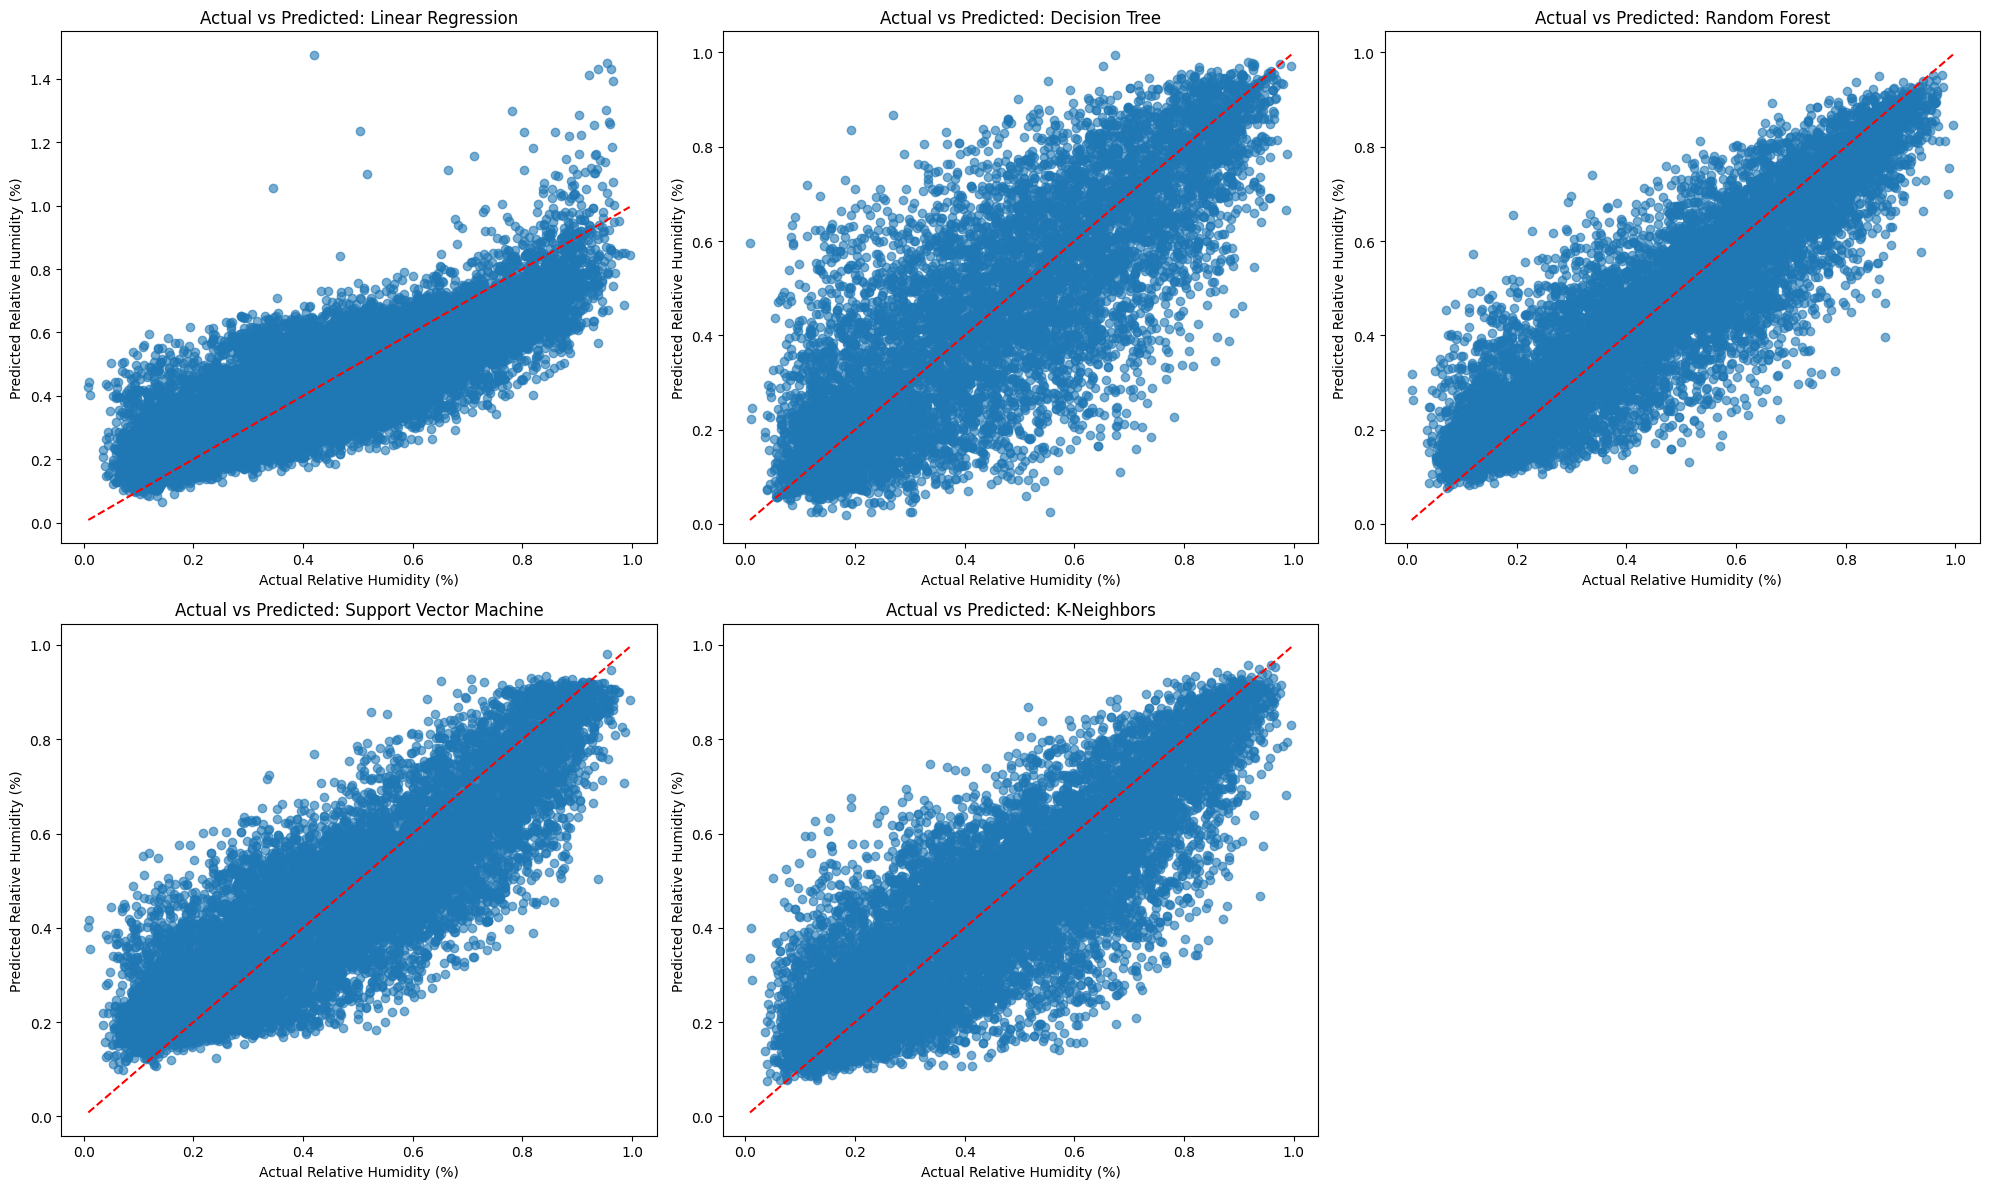

In [44]:
import matplotlib.pyplot as plt

# Set up the figure for subplots
plt.figure(figsize=(20, 12))

# Create subplots for each model
for i, (model_name, model) in enumerate(models.items(), 1):
    plt.subplot(2, 3, i)

    y_pred = model.predict(X_test)

    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line
    plt.xlabel('Actual Relative Humidity (%)')
    plt.ylabel('Predicted Relative Humidity (%)')
    plt.title(f'Actual vs Predicted: {model_name}')

plt.tight_layout()
plt.show()



Ensemble Model - Mean Squared Error (MSE): 0.01
Ensemble Model - Mean Absolute Error (MAE): 0.08


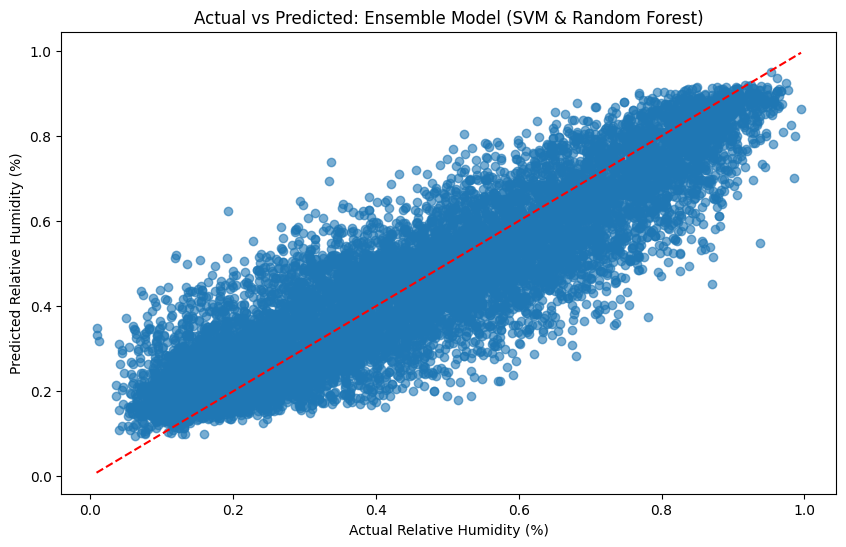

In [45]:
from sklearn.ensemble import VotingRegressor

ensemble_model = VotingRegressor(estimators=[
    ('random_forest', model_rf),
    ('svm', model_svm)
])
ensemble_model.fit(X_train, y_train)

# Make predictions with the ensemble model
y_pred_ensemble = ensemble_model.predict(X_test)

# Calculate MSE and MAE for the ensemble model
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)

# Display the results
print(f"\nEnsemble Model - Mean Squared Error (MSE): {mse_ensemble:.2f}")
print(f"Ensemble Model - Mean Absolute Error (MAE): {mae_ensemble:.2f}")

# Visualize actual vs predicted values for the ensemble model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_ensemble, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line
plt.xlabel('Actual Relative Humidity (%)')
plt.ylabel('Predicted Relative Humidity (%)')
plt.title('Actual vs Predicted: Ensemble Model (SVM & Random Forest)')
plt.show()
